# Prelude

In [1]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import simpy

# Utilities

## Points and Distances

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## PlotMap

In [3]:
def label(i):
    return (label(i//26-1)+chr(65+i%26)) if i>25 else chr(65+i)

In [4]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=3,
            styleP='b-o', lwP=2, msP=3,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, labels=False, scale=False):

    V, E = G

    def round_down(x, level): return (x//level)*level
    def round_up(x, level): return (x//level+1)*level
    
    xmin = round_down(min([ x for (x, _) in V ]), 100)
    xmax = round_up(max([ x for (x, _) in V ]), 100)
    ymin = round_down(min([ y for (_, y) in V ]), 100)
    ymax = round_up(max([ y for (_, y) in V ]), 100)
    dx = xmax-xmin
    dy = ymax-ymin
    yoffset = (ymax-ymin)//10
    
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin-yoffset, ymax)
    
    if not grid:
        plt.axis('off')

    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    if scale:
        # plot 1000m scale
        ybar = ymin-0.9*yoffset
        D = [ (xmin, ybar+50), (xmin, ybar), (xmin+1000, ybar), (xmin+1000, ybar+50) ]
        plt.plot( [ d[0] for d in D ], [ d[1] for d in D ], 'k-', lw=0.5)
        plt.text(xmin+500, ymin-0.7*yoffset, '1000m' , horizontalalignment='center', size=8)
    
    if labels:
        for i in range(len(V)):
            x, y = V[i]
            plt.text(x+0.0150*dx, y-0.0350*dy, label(i), size=8)
        
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
        
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(xmax, ymin-0.7*yoffset, text, horizontalalignment='right', size=8)
    if grid:
        plt.grid()
    plt.show()

## Add Targets

In [5]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Generate Central Warehouse Location

In [6]:
from statistics import median

def generateWarehouseLocation(M):
    V, _ = M
    xc = median([ x for (x, y) in V ])
    yc = median([ y for (x, y) in V ])
    cloc = (xc, yc)
    minloc = V[0]
    mindist = dist(minloc, cloc)
    for i in range(1, len(V)):
        d = dist(V[i], cloc)
        if d<mindist:
            minloc = V[i]
            mindist = dist(V[i], cloc)
    return minloc

## Time Handling (NEW)

**Convention:** In this project we measure simulation time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [7]:
def timestamp(t):
    t = round(t, 1)
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t-secs)*10,1)) 
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [8]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [9]:
timestamp(24*3600*12+3*3600+122.96)

'[12] 03:02:03.0'

In [10]:
def day(now):
    return int(now//(24*3600))

In [11]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

# Finding Shortest Path (as before)

In [12]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [13]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Short Delivery Route (as before)

## Greedy Algorithm

In [14]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [15]:
def createLoopG(M, T, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")

    return makeLoop(L)

# Finding Optimal Delivery Route

## Iterative Integer Programming

In [16]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [17]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [18]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
                
    def cycles(k, n):
        if k==1:
            return [ [i] for i in range(0,n) ]
        else:
            sc=cycles(k-1, n)
            all=[]
            for c in sc:
                for i in range(0,n):
                    if c.count(i)==0:
                        all.append(c+[i])
            return all

    for k in range(3, 4):   
        cycs=cycles(k,n)
        for c in cycs:
            c.append(c[0])
            prob+=pulp.lpSum([ x[c[i]][c[i+1]] for i in range(0,k)]) <= k-1
            constraints += 1    
            
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0, timeLimit=2)
    res = prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
                
        res = prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [19]:
import time

class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None

# Class Customer

<img src='img/EventGraph Customer.png' width=500/>

In [20]:
class Customer:
    
    def __init__(self, rec, id, location):
        self.rec = rec
        self.id = id
        self.location = location
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer {self.id:d} at {str(self.location):s}"
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            answerTime = random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR)
            if answerTime < WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR:                            
                yield self.rec.env.timeout(answerTime)
                self.rec.trace(str(self)+" answers door")
                self.answersDoor = True
            else:
                yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
                self.rec.trace(str(self)+" to slow to answer the door")
                self.answersDoor = False
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec.trace(str(self)+" not at home")
            self.answersDoot = False
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            returnTime = 22 if random.random()<CUSTOMER_NOT_AT_HOME else 18
            yield self.rec.env.timeout(nextHour(self.rec.env, returnTime))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))            


# Class Parcel

<img src='img/EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [21]:
class Parcel:
    
    def __init__(self, rec, i, day, cust):
        self.rec = rec
        self.i = i  
        self.arrival = day
        self.cust = cust
        self.status = [  ] # status record and
        self.timing = [  ] # timing

    def __str__(self):
        return f"Parcel {self.i:d} for cust {self.cust.id:d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.cust.location
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

# Class Driver

<img src='img/EventGraph Driver.png' width=500/>

In [22]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.trace("Driver arrives for work")

    def goesHome(self):
        self.location = None
        self.parcels = None
        self.returns = None
        self.tour = None
        self.rec.trace("Driver goes home")
        
    def leaveForDelivery(self, tour, parcels, addresses):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " 
                       f"of {len(parcels):d} parcels "
                       f"to {len(addresses):d} customers")
        self.rec.trace(f"Length of delivery tour: {pathLength(tour):,d}m")
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):d}:, {pathLength(tour):,d}m")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels, addresses = self.DC.sendForDelivery()
            if len(parcels)==0: 
                self.rec.trace("Nothing to do today")
            else:
                yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
                self.leaveForDelivery(tour, parcels, addresses)        
                while len(self.parcels)>0:
                    # drive to customer
                    custLocation = self.parcels[0].destination()
                    cust = self.parcels[0].cust
                    self.rec.trace("Driver drives to "+str(cust))
                    yield from self.__drive(custLocation)
                    self.rec.trace("Driver arrived at "+str(cust))
                    # call at customer
                    yield from cust.answerDoor()
                    
                    if cust.answersDoor:
                        while len(self.parcels)>0 and \
                                custLocation == self.parcels[0].destination():
                            cust.acceptParcel(self.parcels[0])
                            yield self.rec.env.timeout(random.expovariate(1/10))
                            self.parcels = self.parcels[1:]
                        cust.signOff()
                        yield self.rec.env.timeout(random.expovariate(1/10))
                    else:
                        while len(self.parcels)>0 and  \
                                custLocation == self.parcels[0].destination():
                            self.returns += [self.parcels[0]]
                            self.parcels = self.parcels[1:]

                # return to delivery centre
                self.rec.trace("Driver returns to delivery centre")
                yield from self.__drive(self.DC.W)
                self.rec.trace("Driver arrived at delivery centre")
            
                for parcel in self.returns:
                    self.DC.returnFromDelivery(parcel)
                    yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)

                leftOver = len(self.DC.parcels)+len(self.DC.leftOver)
                self.rec.trace(f"{leftOver:d} parcels left for next day")
            
            yield self.rec.env.timeout(600)
        
            self.goesHome()
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="img/EventGraph Delivery Centre.png" width=300/>

In [23]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = BIKE_RANGE
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [self.W]  # tour planned for delivery
    
    def __accept(self, parcel):
        custLoc = parcel.destination()
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            SH = createLoopG(MT, [self.W] + self.dest + [custLoc])
            if pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = SH
            else: 
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = []
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.destination() == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
                    if dest not in addresses:
                        addresses += [dest]
         
        # arrange the left overs for next day
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)

        return tour, parcels, addresses
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

# Simulation

## Parameters from Specification

The proportion of customers that for whatever are not at home or return home late

In [24]:
CUSTOMER_NOT_AT_HOME = 0.9  # 10%

The maximum bike range. This is passed as parameter to the Delivery Centre
and taken into account for the daily tour planning

In [25]:
BIKE_RANGE = 40000

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [26]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [27]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [28]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [29]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [30]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

## Generate Input Data

In [31]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

## Simulation Routine

In [32]:
def simulation(M, W, C, p=0.2, days=10, seed=0, 
               log=False, plot=False, timing=False):

    random.seed(seed)
    D = generateDeliveries(p, len(C), days, seed)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, 
                   log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {sum([len(d) for d in D]):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    CUSTOMERS = []
    for i in range(len(C)):
        CUSTOMERS.append(Customer(rec, i, C[i]))

    DC = DeliveryCentre(rec, M, W)
    Z = Driver(rec, DC)
    PARCELS = []

    def parcelGeneratorProcess(env, rec, D, C):
        for day in range(len(D)):
            yield env.timeout(nextHour(env, 17.00))
            for c in D[day]:
                cust = CUSTOMERS[c]
                parcel = Parcel(rec, len(PARCELS), day, cust)
                PARCELS.append(parcel)
                DC.acceptParcel(parcel)

    env.process(parcelGeneratorProcess(env, rec, D, C))
    env.run()

    rec.finish()

    if DC.getInventory()>0:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")

    return rec

## Model Verification

In [33]:
import pickle
with open('simpleData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [34]:
W = generateWarehouseLocation(M)

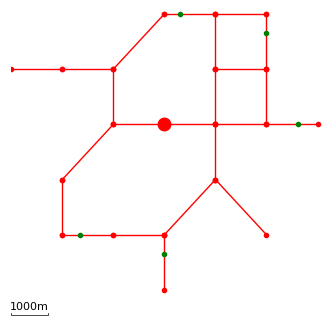

In [35]:
plotMap(M, T=C, w=W, scale=True)

In [36]:
rec1 = simulation(M, W, C, p=0.15, days=4, log=True)

Simulating delivery of 2 parcels over 4 days to 5 customers
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Nothing to do today
[ 0] 18:10:00.0 Driver goes home
[ 1] 18:00:00.0 Driver arrives for work
[ 1] 18:00:00.0 Nothing to do today
[ 1] 18:10:00.0 Driver goes home
[ 2] 18:00:00.0 Driver arrives for work
[ 2] 18:00:00.0 Nothing to do today
[ 2] 18:10:00.0 Driver goes home
[ 3] 17:00:00.0 Parcel 0 for cust 2 arr at delivery centre
[ 3] 17:00:00.0 Parcel 1 for cust 4 arr at delivery centre
[ 3] 18:00:00.0 Driver arrives for work
[ 3] 18:00:00.0 Parcel 0 for cust 2 out for delivery
[ 3] 18:00:00.0 Parcel 1 for cust 4 out for delivery
[ 3] 18:01:40.0 Driver leaves for delivery of 2 parcels to 2 customers
[ 3] 18:01:40.0 Length of delivery tour: 14,876m
[ 3] 18:01:40.0 Driver drives to Customer 2 at (4929, 7300)
[ 3] 18:22:21.0 Driver arrived at Customer 2 at (4929, 7300)
[ 3] 18:23:21.0 Customer 2 at (4929, 7300) not at home
[ 3] 18:23:21.0 Driver drives to Customer 4 at (8167,

Simulating delivery of 6 parcels over 4 days to 5 customers
[ 0] 17:00:00.0 Parcel 0 for cust 0 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 2 arr at delivery centre
[ 0] 17:00:00.0 Parcel 2 for cust 4 arr at delivery centre
[ 0] 17:00:00.0 Parcel 3 for cust 4 arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel 0 for cust 0 out for delivery
[ 0] 18:00:00.0 Parcel 1 for cust 2 out for delivery
[ 0] 18:00:00.0 Parcel 2 for cust 4 out for delivery
[ 0] 18:00:00.0 Parcel 3 for cust 4 out for delivery
[ 0] 18:03:20.0 Driver leaves for delivery of 4 parcels to 3 customers
[ 0] 18:03:20.0 Length of delivery tour: 22,623m


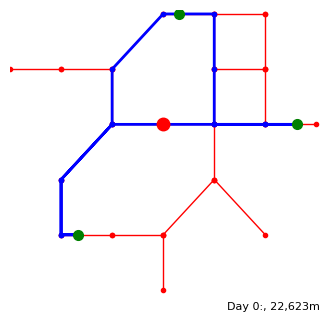

[ 0] 18:03:20.0 Driver drives to Customer 0 at (2176, 1700)
[ 0] 18:24:21.2 Driver arrived at Customer 0 at (2176, 1700)
[ 0] 18:25:21.2 Customer 0 at (2176, 1700) not at home
[ 0] 18:25:21.2 Driver drives to Customer 2 at (4929, 7300)
[ 0] 18:56:00.3 Driver arrived at Customer 2 at (4929, 7300)
[ 0] 18:57:00.3 Customer 2 at (4929, 7300) not at home
[ 0] 18:57:00.3 Driver drives to Customer 4 at (8167, 4500)
[ 0] 19:21:09.4 Driver arrived at Customer 4 at (8167, 4500)
[ 0] 19:22:09.4 Customer 4 at (8167, 4500) not at home
[ 0] 19:22:09.4 Driver returns to delivery centre
[ 0] 19:36:49.5 Driver arrived at delivery centre
[ 0] 19:36:49.5 Parcel 0 for cust 0 return from delivery
[ 0] 19:37:19.5 Parcel 1 for cust 2 return from delivery
[ 0] 19:37:49.5 Parcel 2 for cust 4 return from delivery
[ 0] 19:38:19.5 Parcel 3 for cust 4 return from delivery
[ 0] 19:38:49.5 4 parcels left for next day
[ 0] 19:48:49.5 Driver goes home
[ 1] 18:00:00.0 Driver arrives for work
[ 1] 18:00:00.0 Parcel 0 fo

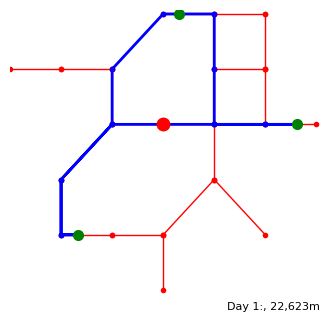

[ 1] 18:03:20.0 Driver drives to Customer 0 at (2176, 1700)
[ 1] 18:24:21.2 Driver arrived at Customer 0 at (2176, 1700)
[ 1] 18:25:21.2 Customer 0 at (2176, 1700) not at home
[ 1] 18:25:21.2 Driver drives to Customer 2 at (4929, 7300)
[ 1] 18:56:00.3 Driver arrived at Customer 2 at (4929, 7300)
[ 1] 18:56:31.5 Customer 2 at (4929, 7300) answers door
[ 1] 18:56:31.5 Customer 2 at (4929, 7300) accepts Parcel 1 for cust 2
[ 1] 18:56:59.5 Customer 2 at (4929, 7300) signs off
[ 1] 18:57:04.3 Driver drives to Customer 4 at (8167, 4500)
[ 1] 19:21:13.4 Driver arrived at Customer 4 at (8167, 4500)
[ 1] 19:22:13.4 Customer 4 at (8167, 4500) not at home
[ 1] 19:22:13.4 Driver returns to delivery centre
[ 1] 19:36:53.5 Driver arrived at delivery centre
[ 1] 19:36:53.5 Parcel 0 for cust 0 return from delivery
[ 1] 19:37:23.5 Parcel 2 for cust 4 return from delivery
[ 1] 19:37:53.5 Parcel 3 for cust 4 return from delivery
[ 1] 19:38:23.5 3 parcels left for next day
[ 1] 19:48:23.5 Driver goes home

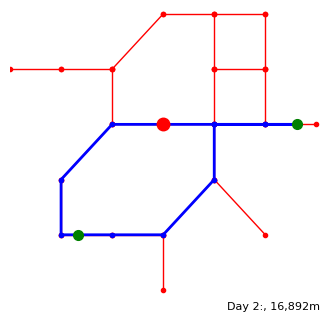

[ 2] 18:02:30.0 Driver drives to Customer 0 at (2176, 1700)
[ 2] 18:23:31.2 Driver arrived at Customer 0 at (2176, 1700)
[ 2] 18:24:31.2 Customer 0 at (2176, 1700) not at home
[ 2] 18:24:31.2 Driver drives to Customer 4 at (8167, 4500)
[ 2] 18:56:24.0 Driver arrived at Customer 4 at (8167, 4500)
[ 2] 18:57:24.0 Customer 4 at (8167, 4500) not at home
[ 2] 18:57:24.0 Driver returns to delivery centre
[ 2] 19:12:04.1 Driver arrived at delivery centre
[ 2] 19:12:04.1 Parcel 0 for cust 0 return from delivery
[ 2] 19:12:34.1 Parcel 2 for cust 4 return from delivery
[ 2] 19:13:04.1 Parcel 3 for cust 4 return from delivery
[ 2] 19:13:34.1 3 parcels left for next day
[ 2] 19:23:34.1 Driver goes home
[ 3] 17:00:00.0 Parcel 4 for cust 2 arr at delivery centre
[ 3] 17:00:00.0 Parcel 5 for cust 3 arr at delivery centre
[ 3] 18:00:00.0 Driver arrives for work
[ 3] 18:00:00.0 Parcel 0 for cust 0 out for delivery
[ 3] 18:00:00.0 Parcel 4 for cust 2 out for delivery
[ 3] 18:00:00.0 Parcel 5 for cust 3 

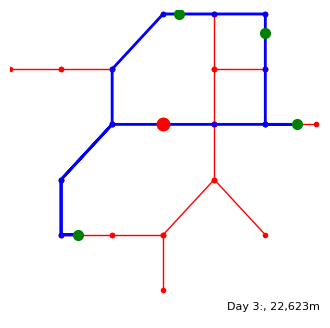

[ 3] 18:04:10.0 Driver drives to Customer 0 at (2176, 1700)
[ 3] 18:25:11.2 Driver arrived at Customer 0 at (2176, 1700)
[ 3] 18:26:11.2 Customer 0 at (2176, 1700) not at home
[ 3] 18:26:11.2 Driver drives to Customer 2 at (4929, 7300)
[ 3] 18:56:50.3 Driver arrived at Customer 2 at (4929, 7300)
[ 3] 18:57:50.3 Customer 2 at (4929, 7300) not at home
[ 3] 18:57:50.3 Driver drives to Customer 3 at (7300, 6825)
[ 3] 19:09:13.4 Driver arrived at Customer 3 at (7300, 6825)
[ 3] 19:10:13.4 Customer 3 at (7300, 6825) not at home
[ 3] 19:10:13.4 Driver drives to Customer 4 at (8167, 4500)
[ 3] 19:22:59.4 Driver arrived at Customer 4 at (8167, 4500)
[ 3] 19:23:59.4 Customer 4 at (8167, 4500) not at home
[ 3] 19:23:59.4 Driver returns to delivery centre
[ 3] 19:38:39.5 Driver arrived at delivery centre
[ 3] 19:38:39.5 Parcel 0 for cust 0 return from delivery
[ 3] 19:39:09.5 Parcel 4 for cust 2 return from delivery
[ 3] 19:39:39.5 Parcel 5 for cust 3 return from delivery
[ 3] 19:40:09.5 Parcel 2 

In [43]:
rec2 = simulation(M, W, C, p=0.3, days=4, seed=1, log=True, plot=True)

In [38]:
rec3 = simulation(M, W, C, p=0.6, days=4, log=True)

Simulating delivery of 12 parcels over 4 days to 5 customers
[ 0] 17:00:00.0 Parcel 0 for cust 1 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 2 arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel 0 for cust 1 out for delivery
[ 0] 18:00:00.0 Parcel 1 for cust 2 out for delivery
[ 0] 18:01:40.0 Driver leaves for delivery of 2 parcels to 2 customers
[ 0] 18:01:40.0 Length of delivery tour: 18,052m
[ 0] 18:01:40.0 Driver drives to Customer 1 at (4500, 1224)
[ 0] 18:22:41.2 Driver arrived at Customer 1 at (4500, 1224)
[ 0] 18:23:41.2 Customer 1 at (4500, 1224) not at home
[ 0] 18:23:41.2 Driver drives to Customer 2 at (4929, 7300)
[ 0] 18:54:11.4 Driver arrived at Customer 2 at (4929, 7300)
[ 0] 18:55:11.4 Customer 2 at (4929, 7300) to slow to answer the door
[ 0] 18:55:11.4 Driver returns to delivery centre
[ 0] 19:15:52.5 Driver arrived at delivery centre
[ 0] 19:15:52.5 Parcel 0 for cust 1 return from delivery
[ 0] 19:16:22.5 Parcel 1 for cu

In [39]:
import pickle
with open('testData.pickled', 'rb') as f:
    MX, CX = pickle.load(f)

In [40]:
WX = generateWarehouseLocation(MX)

In [41]:
rec4 = simulation(MX, WX, CX, p=0.15, days=7, log=True)

Simulating delivery of 14 parcels over 7 days to 20 customers
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Nothing to do today
[ 0] 18:10:00.0 Driver goes home
[ 1] 18:00:00.0 Driver arrives for work
[ 1] 18:00:00.0 Nothing to do today
[ 1] 18:10:00.0 Driver goes home
[ 2] 17:00:00.0 Parcel 0 for cust 4 arr at delivery centre
[ 2] 17:00:00.0 Parcel 1 for cust 12 arr at delivery centre
[ 2] 17:00:00.0 Parcel 2 for cust 19 arr at delivery centre
[ 2] 18:00:00.0 Driver arrives for work
[ 2] 18:00:00.0 Parcel 0 for cust 4 out for delivery
[ 2] 18:00:00.0 Parcel 2 for cust 19 out for delivery
[ 2] 18:00:00.0 Parcel 1 for cust 12 out for delivery
[ 2] 18:02:30.0 Driver leaves for delivery of 3 parcels to 3 customers
[ 2] 18:02:30.0 Length of delivery tour: 18,677m
[ 2] 18:02:30.0 Driver drives to Customer 4 at (2821, 1578)
[ 2] 18:19:48.7 Driver arrived at Customer 4 at (2821, 1578)
[ 2] 18:20:48.7 Customer 4 at (2821, 1578) not at home
[ 2] 18:20:48.7 Driver drives to Customer 19

In [42]:
rec5 = simulation(MX, WX, CX, p=1.2, days=7, log=True)

Simulating delivery of 151 parcels over 7 days to 20 customers
[ 0] 17:00:00.0 Parcel 0 for cust 5 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 6 arr at delivery centre
[ 0] 17:00:00.0 Parcel 2 for cust 6 arr at delivery centre
[ 0] 17:00:00.0 Parcel 3 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 4 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 5 for cust 8 arr at delivery centre
[ 0] 17:00:00.0 Parcel 6 for cust 13 arr at delivery centre
[ 0] 17:00:00.0 Parcel 7 for cust 13 arr at delivery centre
[ 0] 17:00:00.0 Parcel 8 for cust 15 arr at delivery centre
[ 0] 17:00:00.0 Parcel 9 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 10 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 11 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 12 for cust 17 arr at delivery centre
[ 0] 17:00:00.0 Parcel 13 for cust 17 arr at delivery centre
[ 0] 17:00:00.0 Parcel 14 for cust 18 arr at delivery centre
[ 0] 17:00:00.0 Parcel 15 for cust 19 